In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Метод конечных элементов


Для  $k(x) = e^{\alpha x} $ получаем:
\begin{align*}
\int_{x_{i-1}}^{x_i} k(x)  dx = \frac{e^{\alpha x_i} - e^{\alpha x_{i-1}}}{\alpha}, \quad
\int_{x_i}^{x_{i+1}} k(x)  dx = \frac{e^{\alpha x_{i+1}} - e^{\alpha x_i}}{\alpha}
\end{align*}

Матрица \( A \) трёхдиагональная, вычислим её ненулевые элементы:
\begin{align*}
A_{ii} &= \frac{1}{h^2} \left[ \frac{e^{\alpha x_i} - e^{\alpha x_{i-1}}}{\alpha} +  \frac{e^{\alpha x_{i+1}} - e^{\alpha x_i}}{\alpha} \right] + 4 \cdot \frac{2h}{3} = \frac{1}{h^2\alpha}  (e^{\alpha x_{i+1}}  - e^{\alpha x_{i-1}}) +   \frac{8h}{3}, \\
A_{i,i+1} &= A_{i+1,i} = -\frac{1}{h^2 \alpha}  (e^{\alpha x_{i+1}} - e^{\alpha x_i}) +  \frac{2h}{3}
\end{align*}


Для граничных узлов ($i=1$ и $i=N-1$) формулы корректируются с учётом граничных условий:

\begin{align*}
A_{11} &= \frac{1}{h^2\alpha}\left(e^{\alpha x_2} - e^{\alpha x_0}\right) + \frac{8h}{3} \\
A_{N-1,N-1} &= \frac{1}{h^2\alpha}\left(e^{\alpha x_N} - e^{\alpha x_{N-2}}\right) + \frac{8h}{3}
\end{align*}


In [168]:
def method_finite_element_func(n, alpha, f):
    h = 1.0 / n
    x_nodes = np.linspace(0, 1, n+1)
    A = np.zeros((n-1, n-1))
    b = np.zeros(n-1)
    
    for i in range(0, n-1):
        x_i = x_nodes[i+1]
        x_im1 = x_nodes[i]
        x_ip1 = x_nodes[i+2]
        
        if alpha == 0:
            A[i, i] = 2.0 / h + 8 * h / 3
        else:
            A[i, i] = (np.exp(alpha * x_ip1) - np.exp(alpha * x_im1)) / (h**2 * alpha) + 8 * h / 3
        
        if i < n-2:
            if alpha == 0:
                A[i, i+1] = -1.0 / h + 2 * h / 3
                A[i+1, i] = -1.0 / h + 2 * h / 3
            else:
                A[i, i+1] = -(np.exp(alpha * x_ip1) - np.exp(alpha * x_i)) / (h**2 * alpha) + 2 * h / 3
                A[i+1, i] = -(np.exp(alpha * x_ip1) - np.exp(alpha * x_i)) / (h**2 * alpha) + 2 * h / 3
    
    gauss_points = [-1/np.sqrt(3), 1/np.sqrt(3)]
    weights = [1, 1]
    
    for i in range(n):
        left_node = x_nodes[i]
        right_node = x_nodes[i+1]
        length = right_node - left_node
        
        f_local = np.zeros(2)
        
        for point, weight in zip(gauss_points, weights):
            xi = (left_node + right_node)/2 + (length/2)*point
            w = weight * (length/2)
            
            phi0 = (right_node - xi) / length
            phi1 = (xi - left_node) / length
            
            f_val = f(xi)
            
            f_local[0] += w * f_val * phi0
            f_local[1] += w * f_val * phi1
        
        if i > 0:
            b[i-1] += f_local[0]
        if i < n-1:
            b[i] += f_local[1]
    
    return A, b, x_nodes

# Решение СЛАУ

Для решения трёхдиагональной системы используется метод прогонки (алгоритм Томаса):

Прямой ход:
\begin{align*}
C_1 &= \frac{A_{12}}{A_{11}} \\
D_1 &= \frac{b_1}{A_{11}} \\
C_i &= \frac{A_{i,i+1}}{A_{ii} - A_{i,i-1}C_{i-1}} \\
D_i &= \frac{b_i - A_{i,i-1}D_{i-1}}{A_{ii} - A_{i,i-1}C_{i-1}}
\end{align*}

Обратный ход:
\begin{align*}
x_{N-1} &= D_{N-1} \\
x_i &=   D_i - C_i x_{i+1}
\end{align*}

In [62]:
def thomas_algorithm(A, b):
    n = len(b)
    
    main_diag = np.diag(A).astype(float)
    upper_diag = np.diag(A, k=1).astype(float)
    lower_diag = np.diag(A, k=-1).astype(float)
    
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)
    
    c_prime[0] = upper_diag[0] / main_diag[0]
    d_prime[0] = b[0] / main_diag[0]
    
    for i in range(1, n-1):
        denominator = main_diag[i] - lower_diag[i-1] * c_prime[i-1]
        c_prime[i] = upper_diag[i] / denominator
        d_prime[i] = (b[i] - lower_diag[i-1] * d_prime[i-1]) / denominator
    
    denominator = main_diag[n-1] - lower_diag[n-2] * c_prime[n-2]
    d_prime[n-1] = (b[n-1] - lower_diag[n-2] * d_prime[n-2]) / denominator
    
    x = np.zeros(n)
    x[n-1] = d_prime[n-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x

In [112]:
def is_tridiagonal(A):
    """
    Проверяет, является ли матрица A трехдиагональной.
    """
    n = A.shape[0]
    
    mask = np.zeros_like(A, dtype=bool)
    np.fill_diagonal(mask, True)
    np.fill_diagonal(mask[1:], True)
    np.fill_diagonal(mask[:,1:], True)
    
    return np.allclose(A, A * mask)

# Точное аналитическое решение 

In [64]:
def exact_solution(x, f_type, alpha):
    if f_type == 'zero':
        return np.zeros_like(x)
    elif f_type == 'const':
        if alpha == 0:
            C1 = (np.exp(-2) - 1) / (4*(np.exp(2) - np.exp(-2)))
            C2 = (1 - np.exp(2)) / (4*(np.exp(2) - np.exp(-2)))
            return C1*np.exp(2*x) + C2*np.exp(-2*x) + 1/4
        else:
            return None 
    elif f_type == 'sin':
        if alpha == 0:
            return np.sin(np.pi*x) / (np.pi**2 + 4)
        else:
            return None
    elif f_type == 'sin_7':
        if alpha == 0:
            return np.sin(7*np.pi*x) / (49 * np.pi**2 + 4)
        else:
            return None
    return None

# Сравнение решений

In [66]:
def solve_and_compare(n, alpha, f, f_type, save_flg=0, name=''):
    A, b, x_nodes = method_finite_element_func(n, alpha, f)
    u_internal = thomas_algorithm(A, b) #np.linalg.solve(A, b)
    u_numerical = np.zeros(n+1)
    u_numerical[1:n] = u_internal
    
    u_exact = exact_solution(x_nodes, f_type, alpha)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_nodes, u_numerical, 'o-', label='Численное решение')
    if u_exact is not None:
        plt.plot(x_nodes, u_exact, '-', label='Точное решение')
        error = np.max(np.abs(u_numerical - u_exact))
        plt.title(f'Сравнение решений (n={n}, α={alpha}), Макс. ошибка: {error:.2e}')
    else:
        plt.title(f'Численное решение (n={n}, α={alpha})')
    
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.grid(True)
    
    if save_flg:
        plt.savefig(f'{name}.png')
        
    plt.show()

In [68]:
def solve_and_compare_alphas(n, alpha_values, f, f_type, title='', save_flg=0, name=''):
    plt.figure(figsize=(10, 6))
    
    for alpha in alpha_values:
        A, b, x_nodes = assemble_system(n, alpha, f)
        u_internal = np.linalg.solve(A, b)
        u_numerical = np.zeros(n+1)
        u_numerical[1:n] = u_internal
        plt.plot(x_nodes, u_numerical, '-', label=alpha)
        
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.grid(True)

    if save_flg:
        plt.savefig(f'{name}.png')
    plt.show()

# Примеры

## Случай 1: $f(x) = 0$

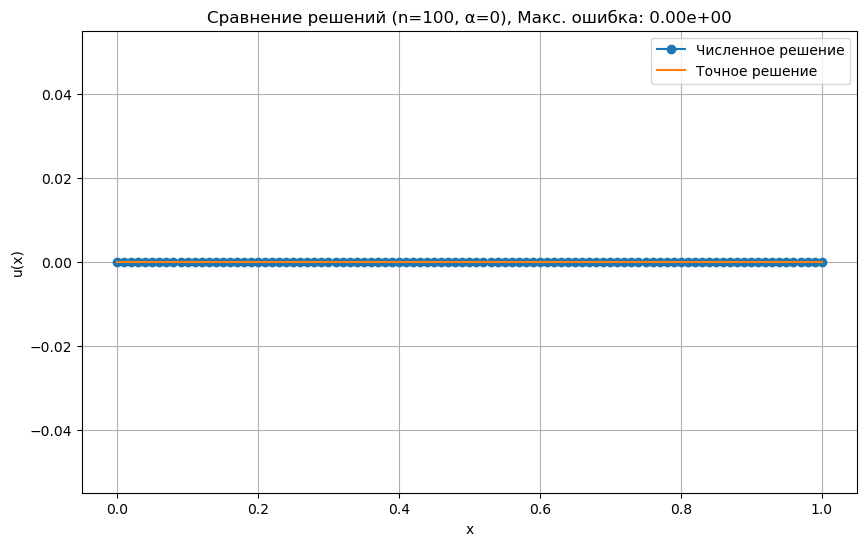

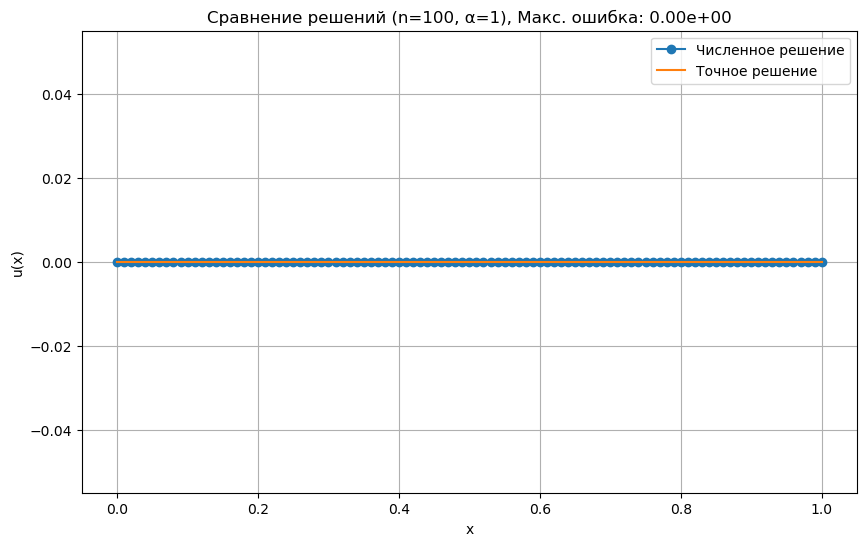

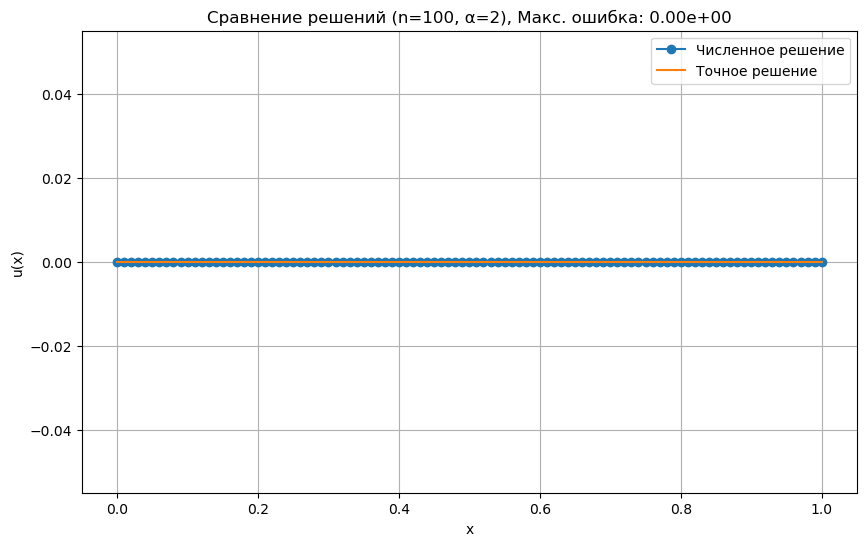

In [72]:
n = 100
alpha_values = [0, 1, 2]

f_zero = lambda x: np.zeros_like(x)

for alpha in alpha_values:
    solve_and_compare(n, alpha, f_zero, 'zero')

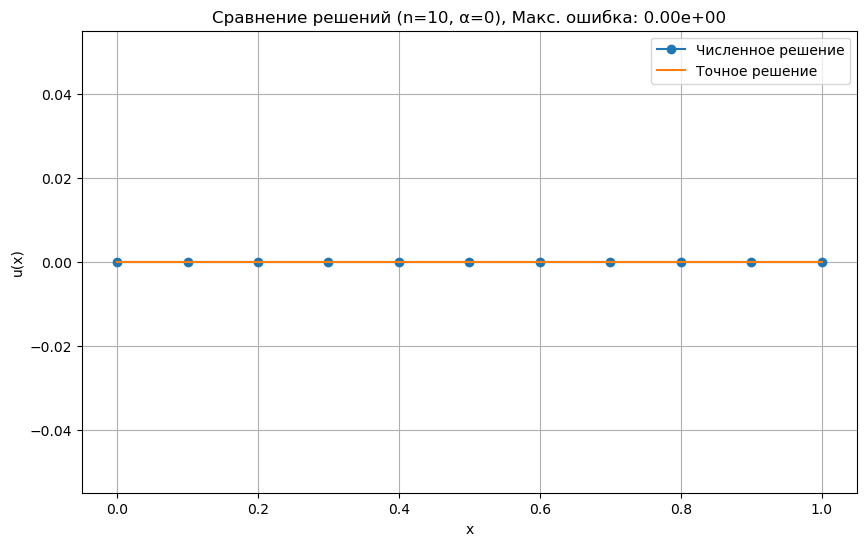

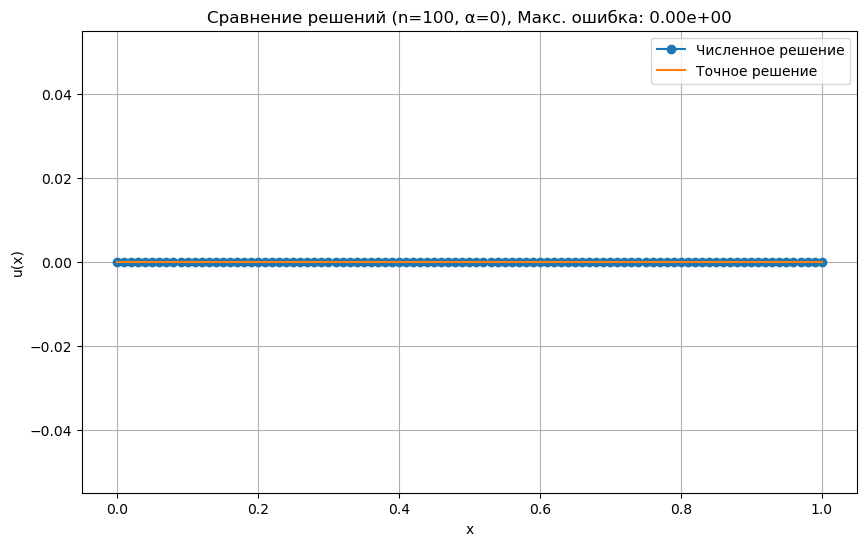

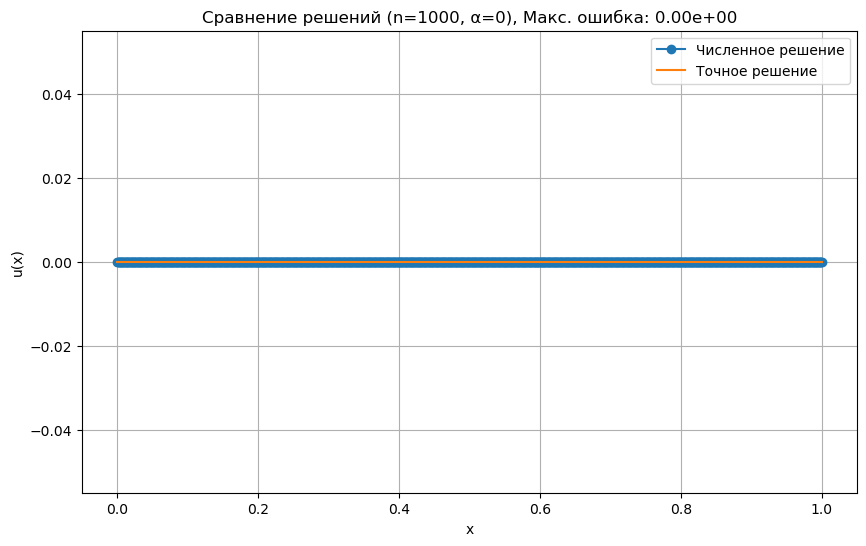

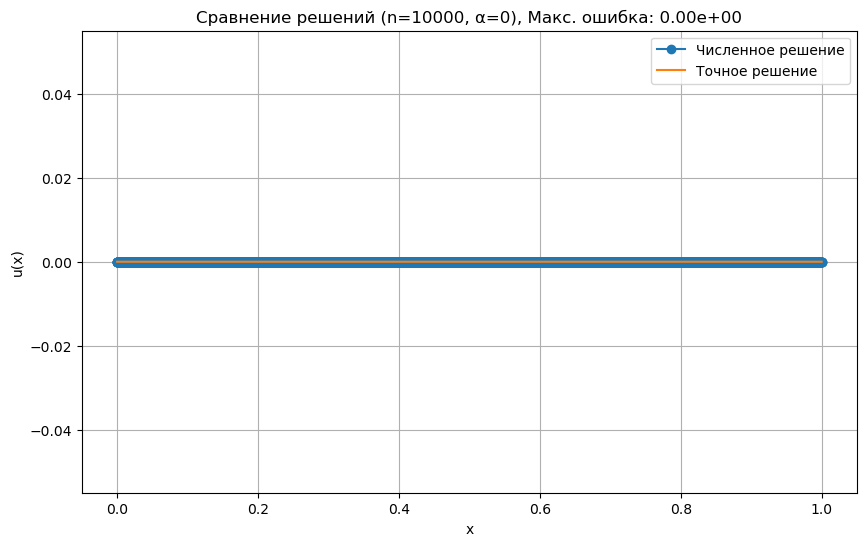

In [100]:
alpha_values = [0]
n_values = [10, 100, 1000, 10000]

f_zero = lambda x: np.zeros_like(x)

for n in n_values:
    for alpha in alpha_values:
        solve_and_compare(n, alpha, f_zero, 'zero')

## Случай 2: $f(x) = 1$

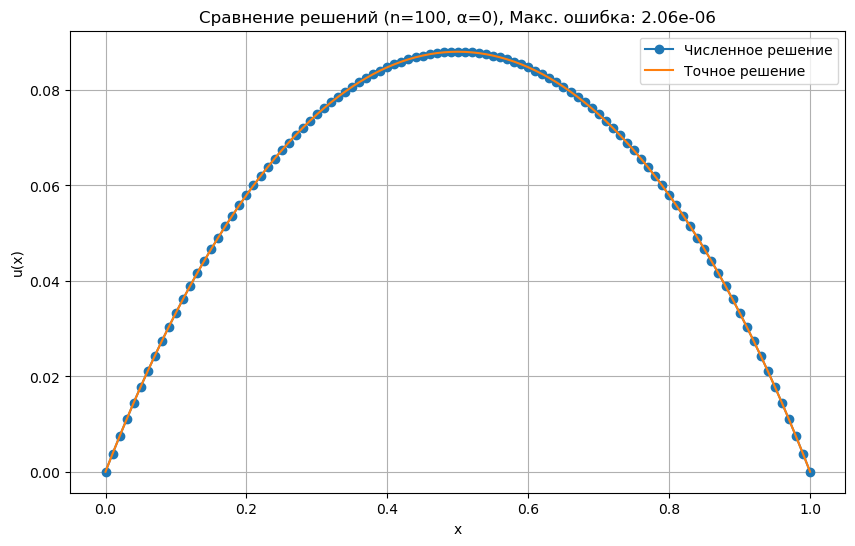

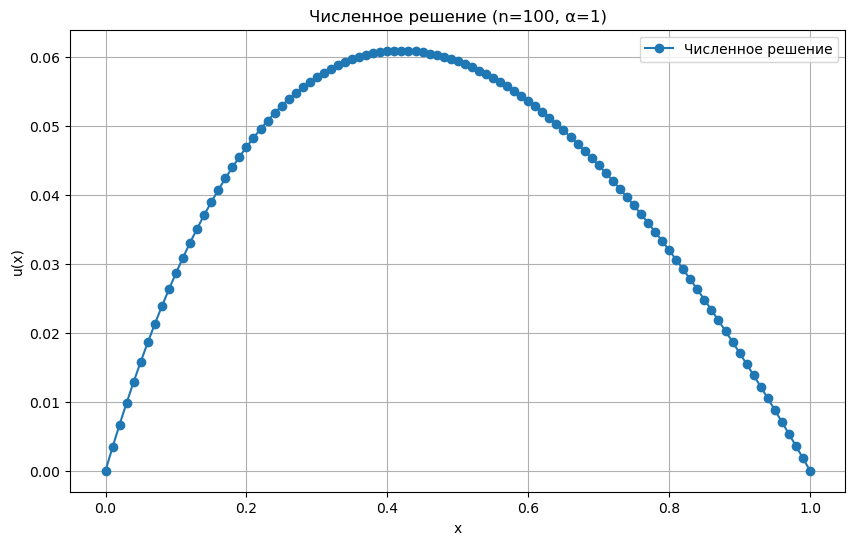

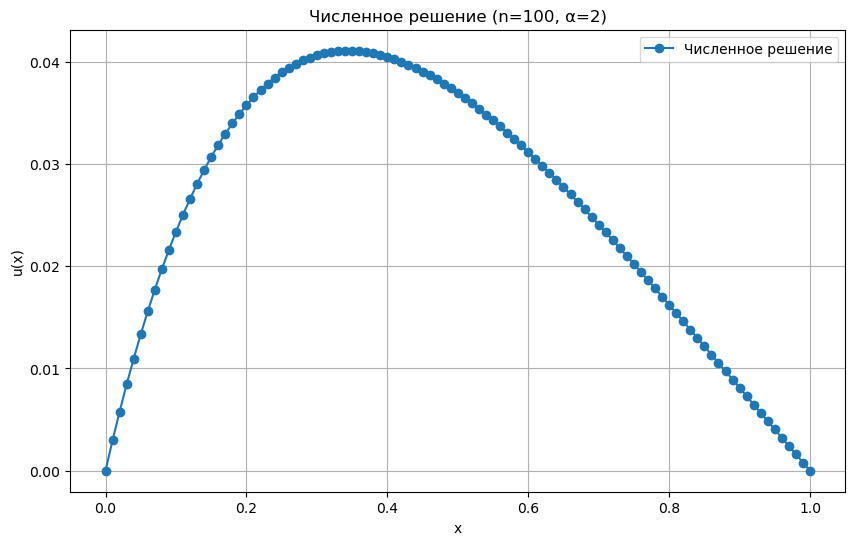

In [80]:
n = 100
alpha_values = [0, 1, 2]

f_const = lambda x: np.ones_like(x)
for alpha in alpha_values:
    solve_and_compare(n, alpha, f_const, 'const')


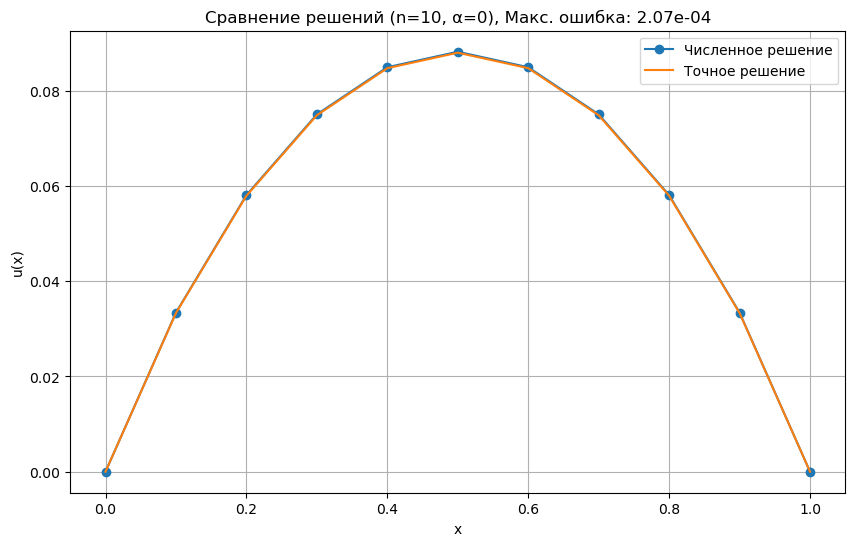

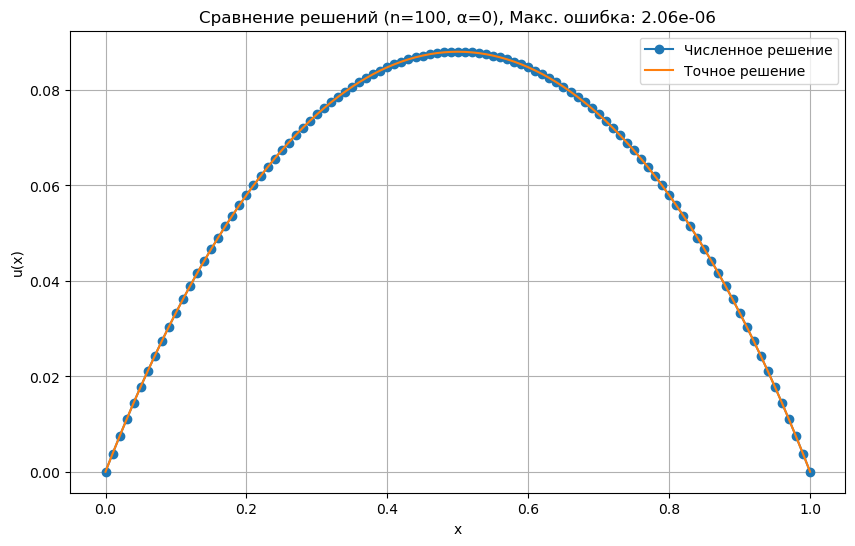

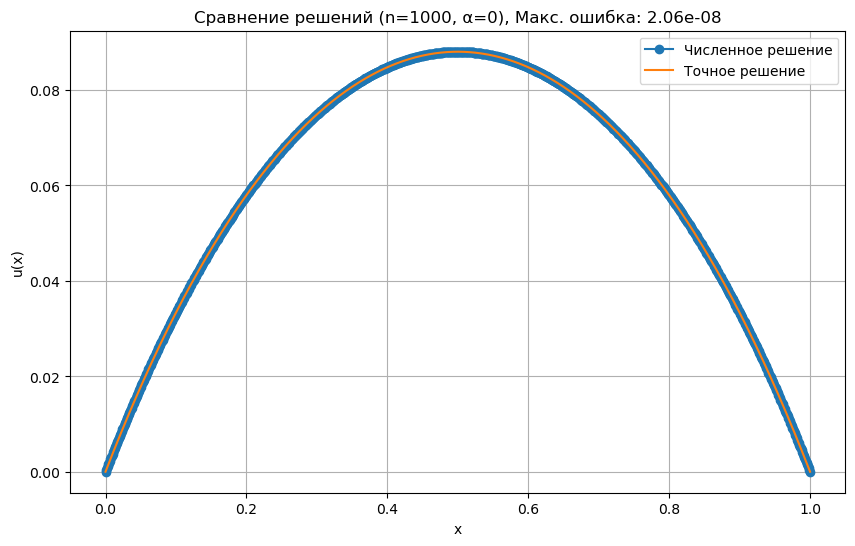

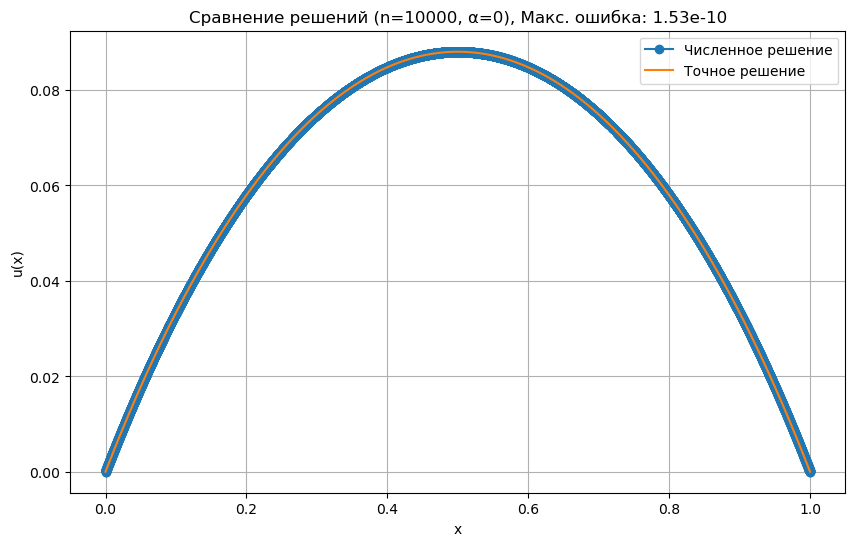

In [84]:
alpha_values = [0]
n_values = [10, 100, 1000, 10000]

f_const = lambda x: np.ones_like(x)

for n in n_values:
    for alpha in alpha_values:
        solve_and_compare(n, alpha, f_const, 'const')

## Случай 3: $f(x) = sin(πx)$

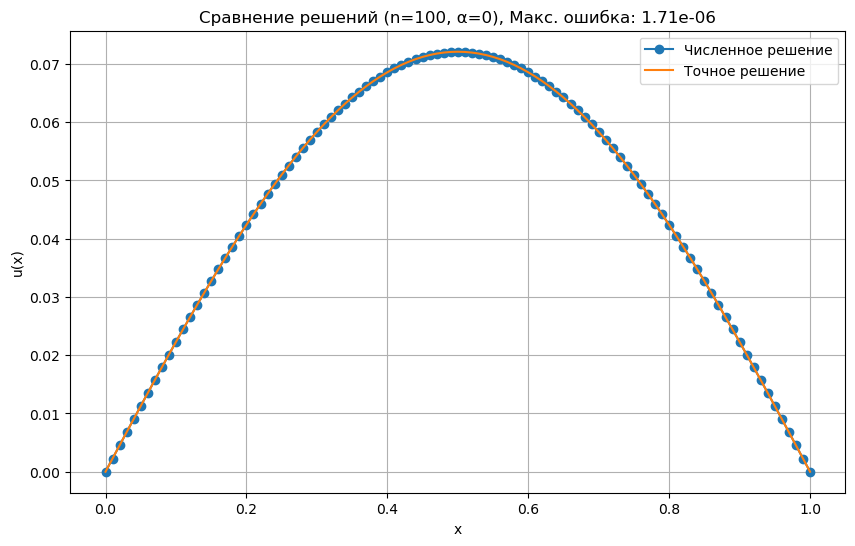

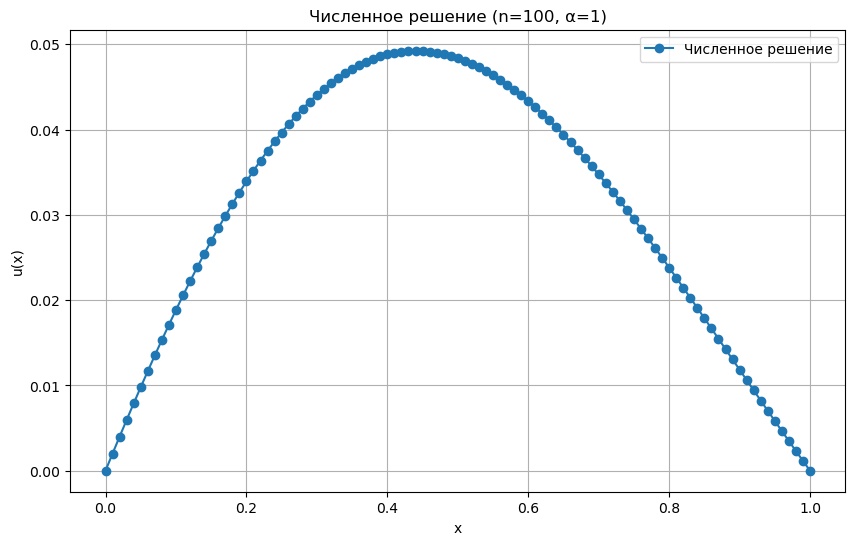

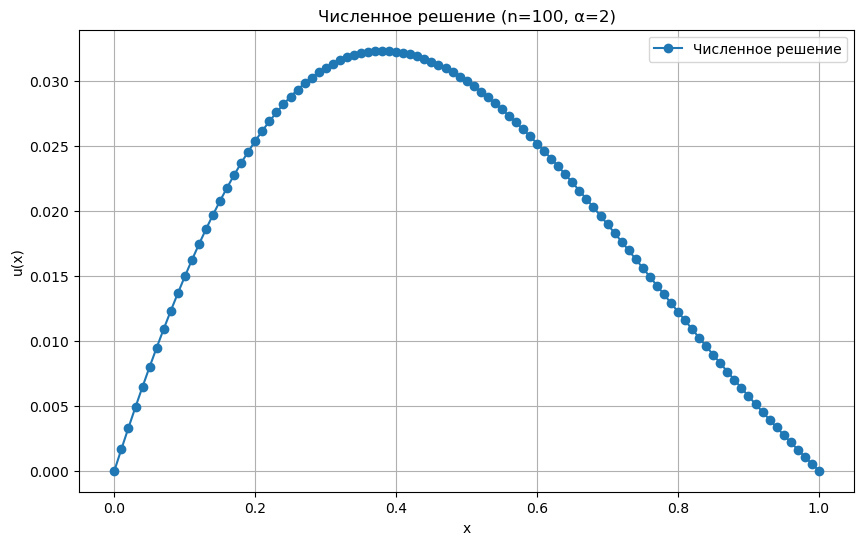

In [87]:
n = 100
alpha_values = [0, 1, 2]

f_sin = lambda x: np.sin(np.pi * x)

for alpha in alpha_values:
    solve_and_compare(n, alpha, f_sin, 'sin')


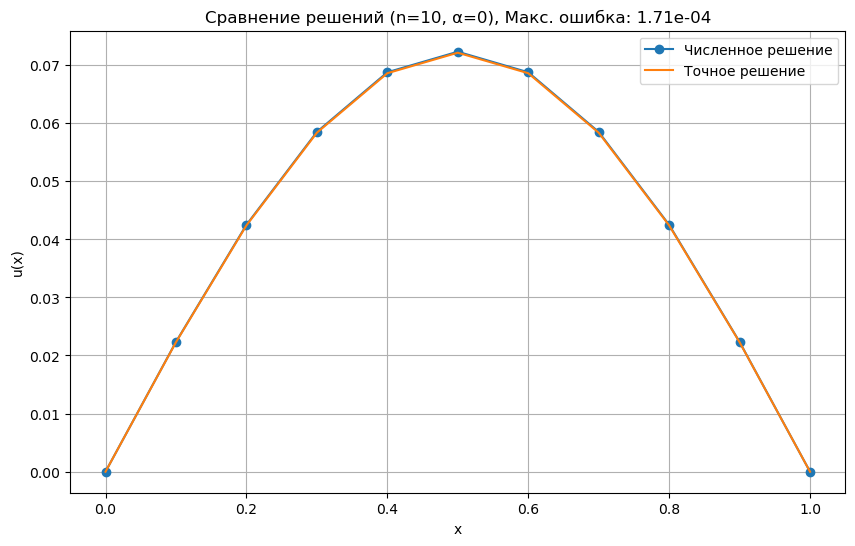

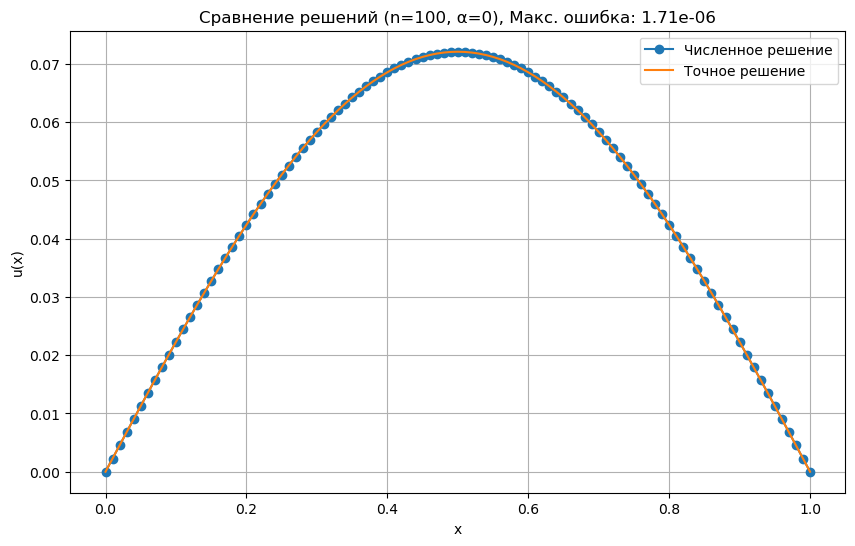

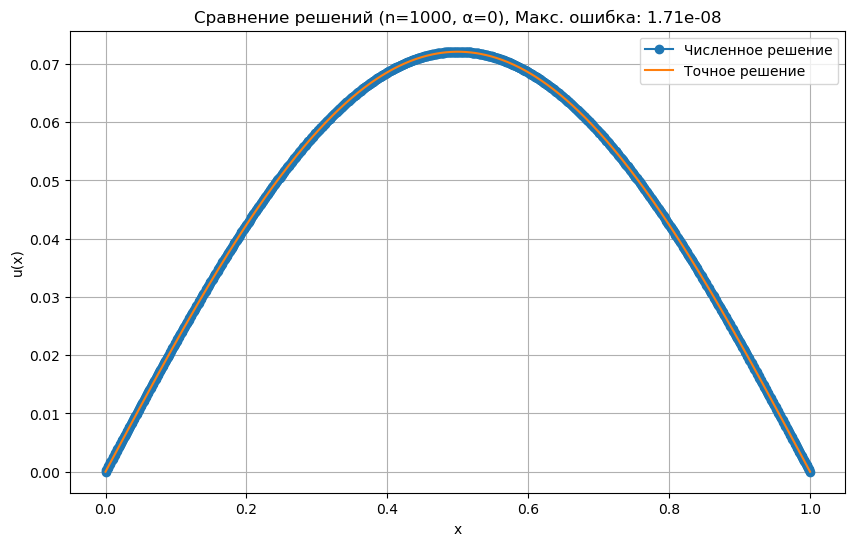

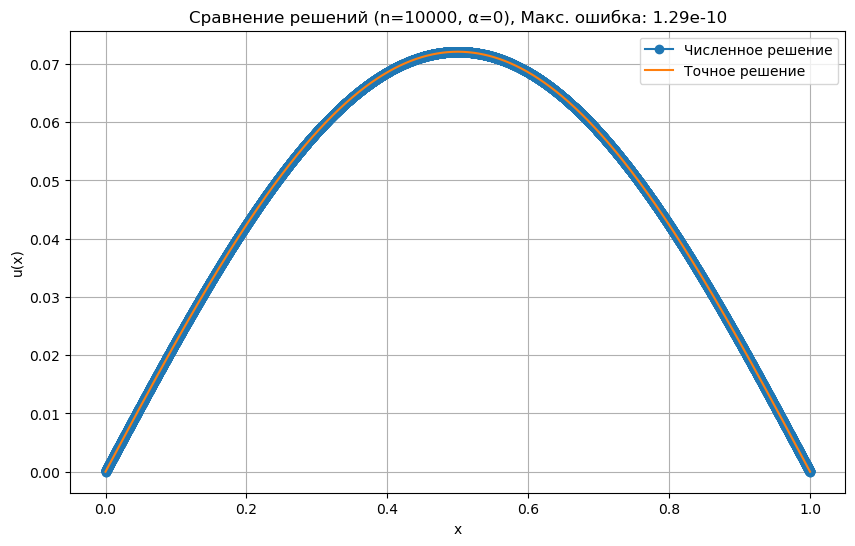

In [91]:
alpha_values = [0]
n_values = [10, 100, 1000, 10000]

f_sin = lambda x: np.sin(np.pi * x)

for n in n_values:
    for alpha in alpha_values:
        solve_and_compare(n, alpha,  f_sin, 'sin')

## Случай 4: $f(x) = sin(7πx)$

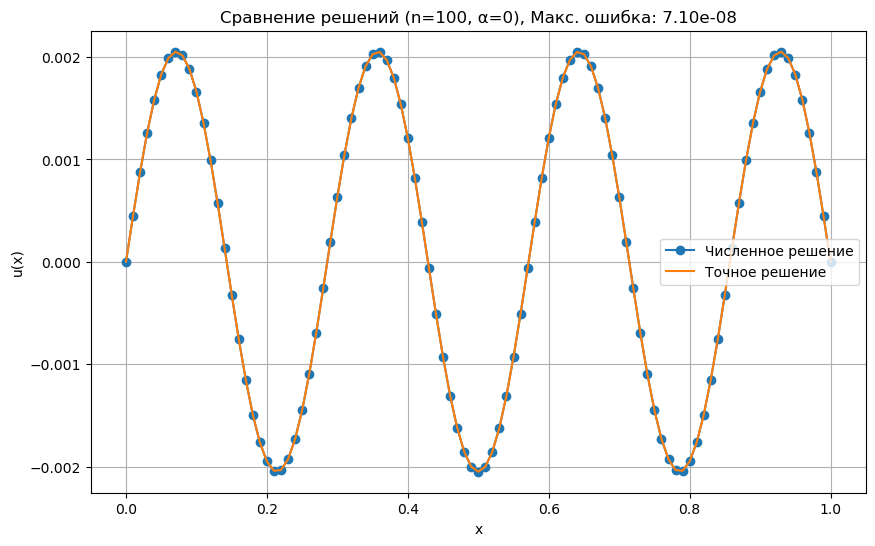

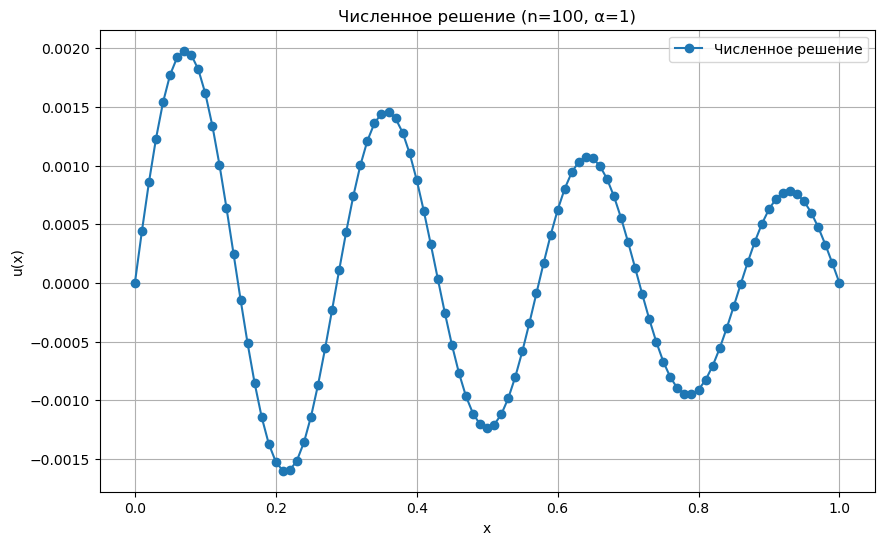

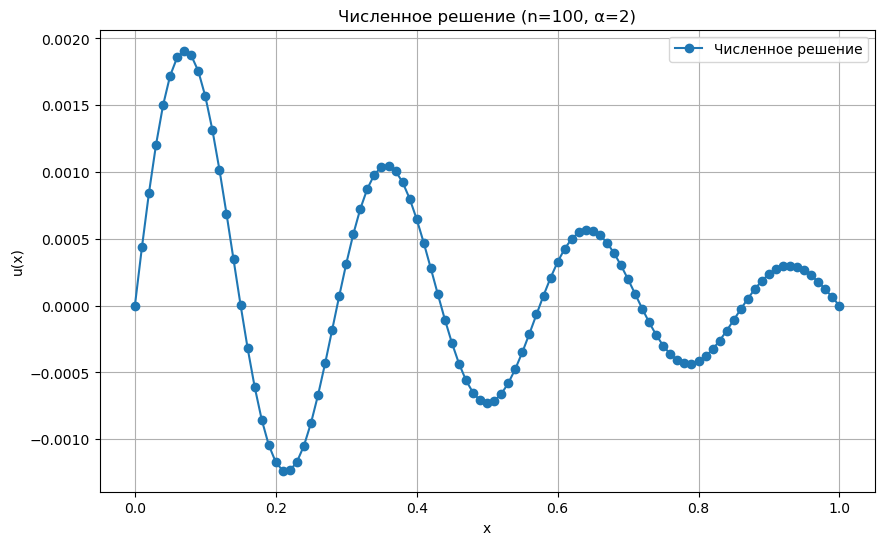

In [94]:
n = 100
alpha_values = [0, 1, 2]


f_sin = lambda x: np.sin(7 * np.pi * x)
for alpha in alpha_values:
    solve_and_compare(n, alpha, f_sin, 'sin_7')


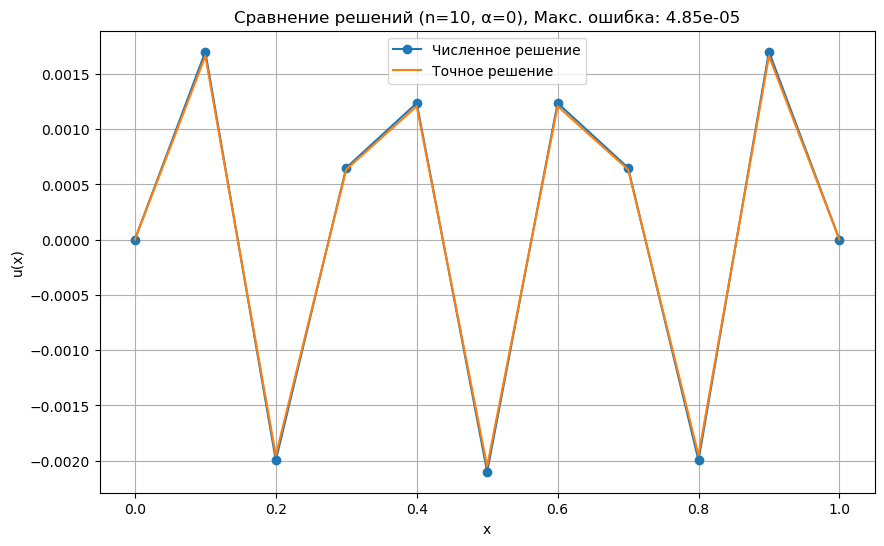

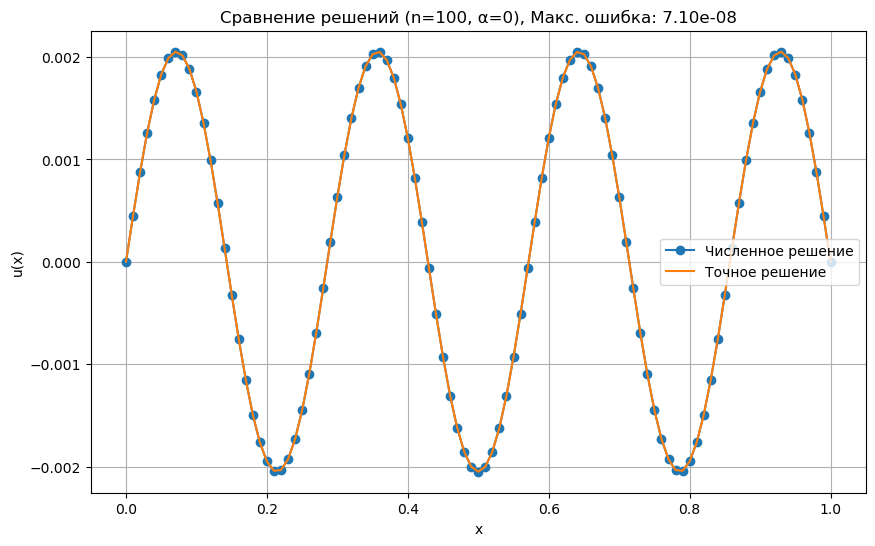

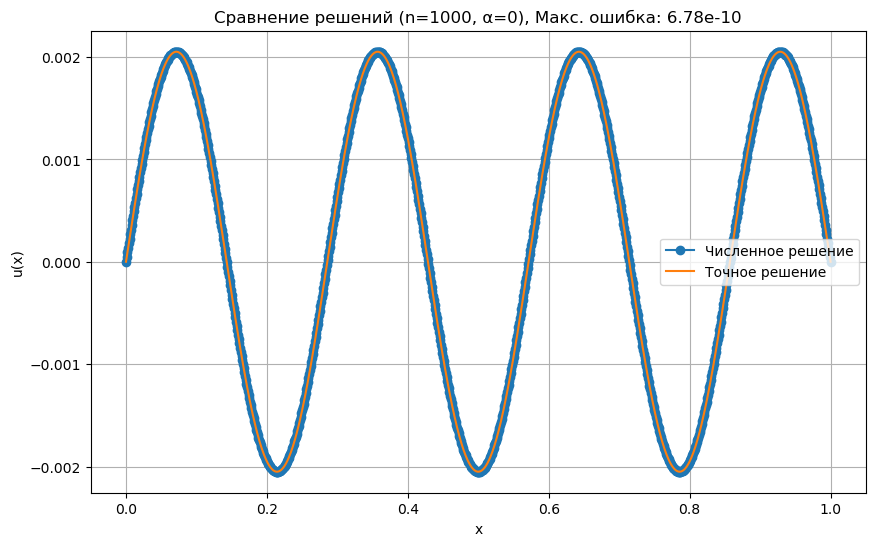

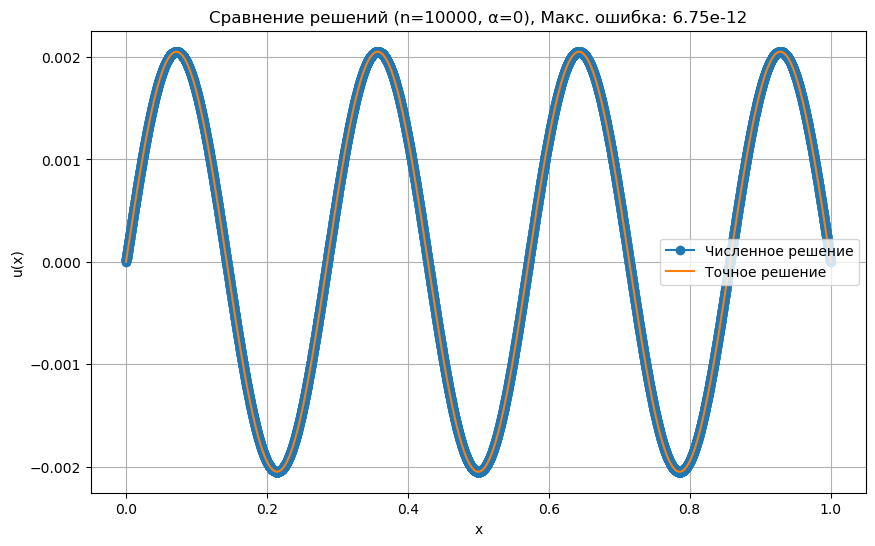

In [98]:
alpha_values = [0]
n_values = [10, 100, 1000, 10000]
f_sin = lambda x: np.sin(7 * np.pi * x)

for n in n_values:
    for alpha in alpha_values:
        solve_and_compare(n, alpha,  f_sin, 'sin_7')

## Сравниваем разные $\alpha$

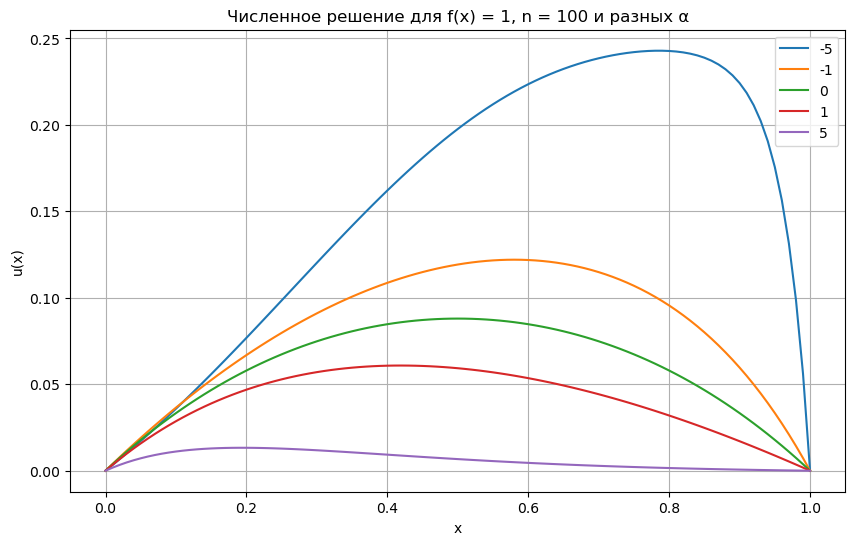

In [106]:
alpha_values = [-5,  -1,  0, 1, 5]
n = 100
name = 'const_100_alphas'

f_const = lambda x: np.ones_like(x)
title = f'Численное решение для f(x) = 1, n = {n} и разных α'
solve_and_compare_alphas(n, alpha_values, f_const, 'const', title=title)


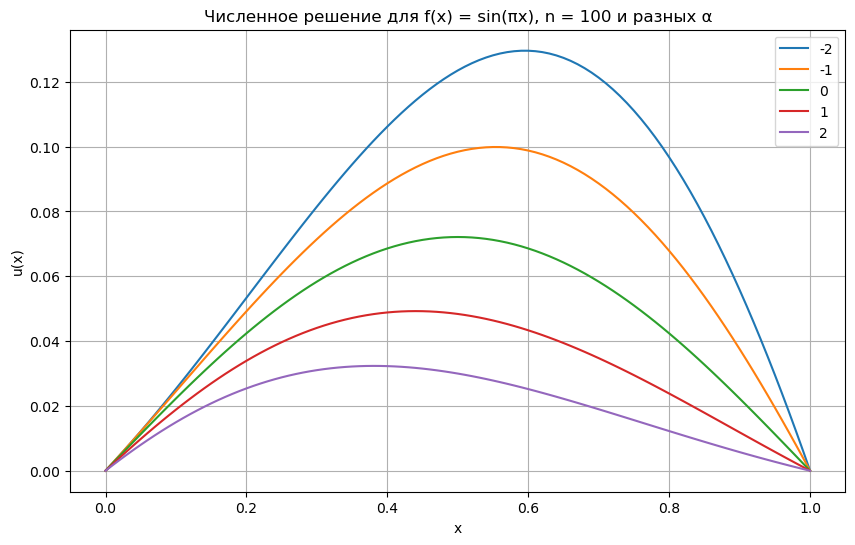

In [110]:
alpha_values = [-2,  -1,  0, 1, 2]
n = 100

name = 'sin_100_alphas'

f_sin = lambda x: np.sin(np.pi * x)
title = f'Численное решение для f(x) = sin(πx), n = {n} и разных α'

solve_and_compare_alphas(n, alpha_values, f_sin, 'sin', title=title)

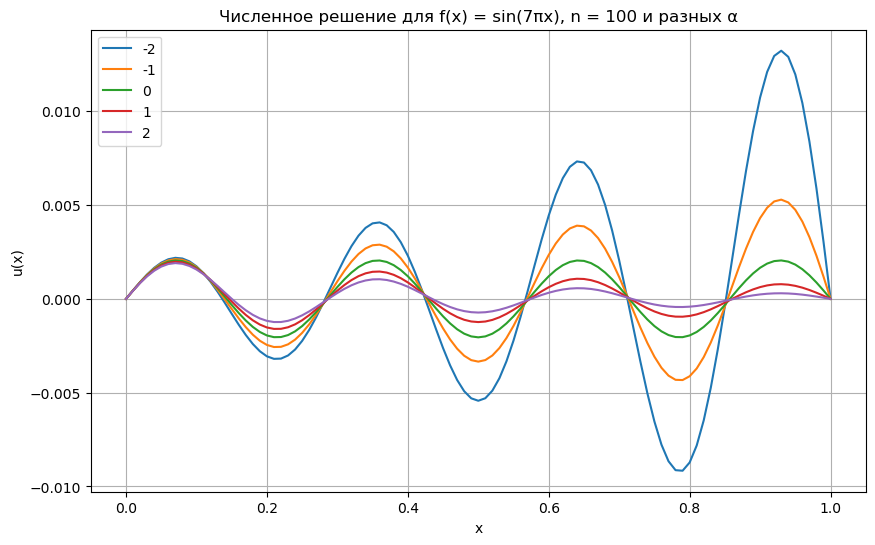

In [108]:
alpha_values = [-2,  -1,  0, 1, 2]
n = 100

name = 'sin7_100_alphas'

f_sin_7 = lambda x: np.sin(7 * np.pi * x)
title = f'Численное решение для f(x) = sin(7πx), n = {n} и разных α'
solve_and_compare_alphas(n, alpha_values, f_sin_7, 'sin_7', title=title)


# Дополнительные тесты

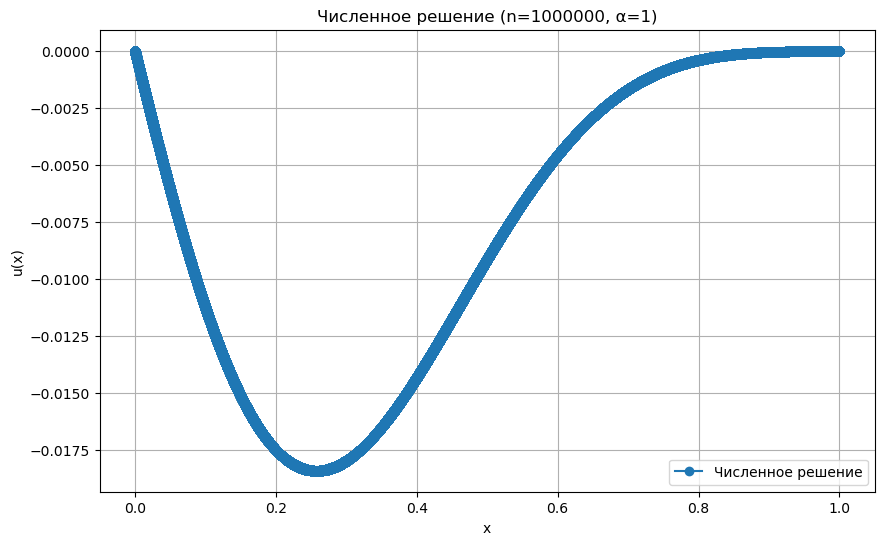

In [166]:
function_1 = lambda x: np.sin(2 * np.pi * x) * (x - 1)
n = 1000000
alpha = 1

solve_and_compare(n, alpha, function_1, 'castom_function')

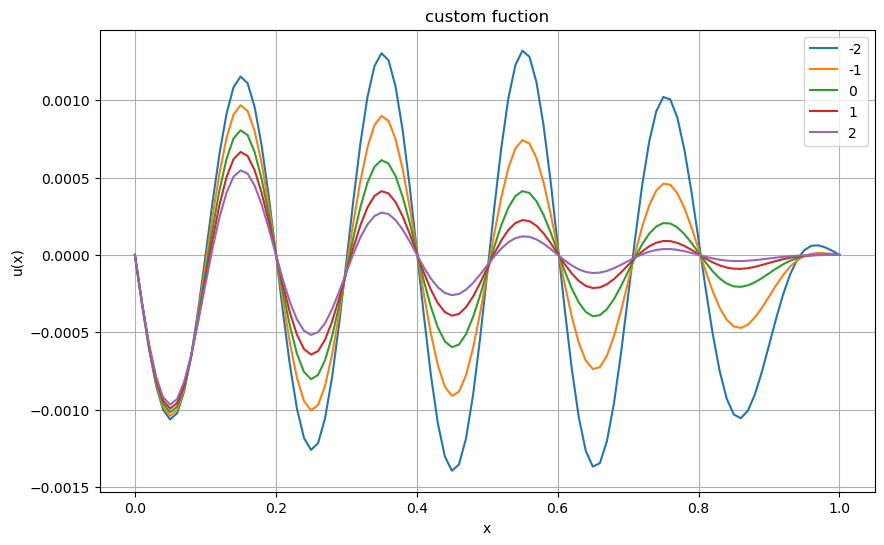

In [164]:
alpha_values = [-2,  -1,  0, 1, 2]
n = 100
title = 'custom fuction'

solve_and_compare_alphas(n, alpha_values, function_1, 'castom_function', title=title)

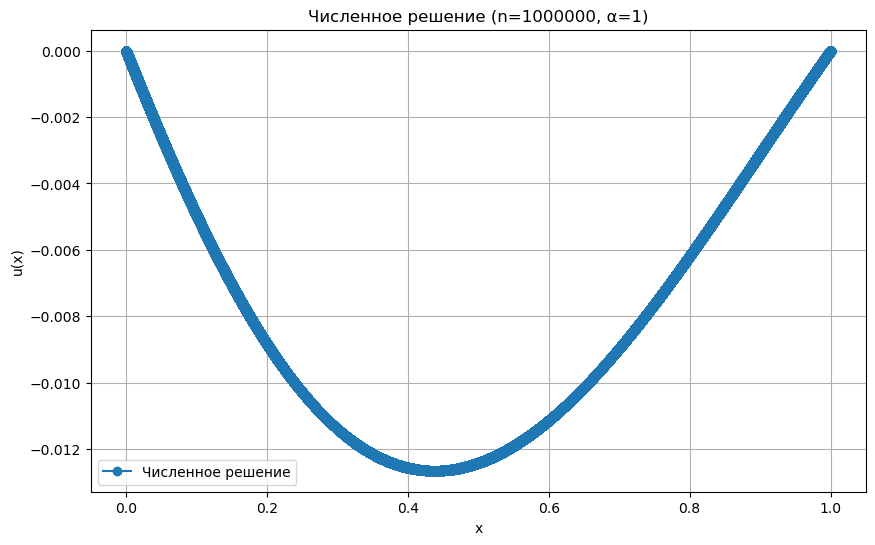

In [158]:
function_2 = lambda x: (x-1)*x
n = 1000000
alpha = 1

solve_and_compare(n, alpha, function_2, 'castom_function')

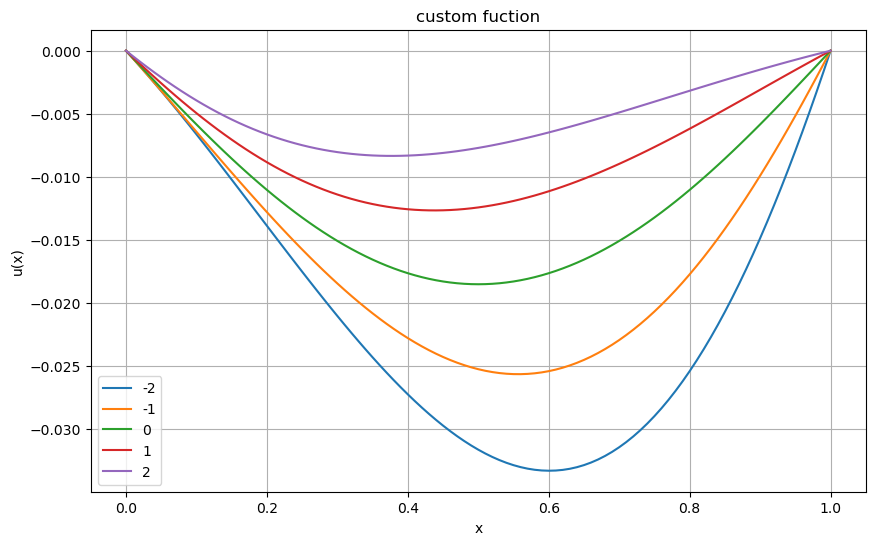

In [160]:
alpha_values = [-2,  -1,  0, 1, 2]
n = 100
title = 'custom fuction'

solve_and_compare_alphas(n, alpha_values, function_2, 'castom_function', title=title)